In [80]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

import seaborn as sb   # Heatmaps
import matplotlib.pyplot as plt

import mit_util #For plotting loss over time

import numpy as np
from music21 import *
from copy import deepcopy
import random
import pickle
import os
import itertools
import time
from tqdm import tqdm

PICKLES_DIRECTORY = 'pickles'

### Data Loading/Preprocessing

In [2]:
with open(f"{PICKLES_DIRECTORY}/int_short_seqs_pitch.pickle", 'rb') as int_short_pitch:
    pitch_seq = pickle.load(int_short_pitch)

In [3]:
#Shuffle the sequences so that transposed versions are not all adjacent
# random.seed(0)
# pitch_seq = random.sample(pitch_seq, len(pitch_seq))
# pitch_seq

In [4]:
#Define and create vocab list of different pitches
pitch_vocab = []

pitches = itertools.chain(*pitch_seq)
for p in pitches:
    if p not in pitch_vocab:
        pitch_vocab.append(p)

In [5]:
pitch_vocab = sorted(pitch_vocab)
print("There are", len(pitch_vocab), "unique characters in the dataset")
#pitch_vocab

There are 44 unique characters in the dataset


In [6]:
#Defines the dimension of the vocabulary of unique pitches
vocab_size = len(pitch_vocab)

### Helper Functions

In [7]:
# Create a dictionary mapping from MIDI number/rest to unique index.
# For example, to get the index of the midi pitch `69`, we can evaluate `char2idx[69]`.  
# A rest `-1` would be evaluated by `char2idx[-1]`.
midi2idx = {u:i for i, u in enumerate(pitch_vocab)}
#midi2idx


# Create a mapping from indices to midi pitches. This is
#   the inverse of midi2idx and allows us to convert back
#   from unique index to the midi pitch in our vocabulary.
idx2midi = np.array(pitch_vocab)
#idx2midi

In [8]:
### Converts the dataset MIDI pitches to their corresponding index values
# ------------------------------------------------------------------------
### Input: a 2D list of chorale MIDI pitches of dim.          (num_pieces X sequence_len)
### Output: a 2D numpy array of chorale index numbers of dim. (num_pieces X sequence_len)
def vectorize_seqs(pitch_seqs):
    vectorized_pieces = []
    for seq in pitch_seqs:
        vectorized_seqs = []
        for p in seq:
            vectorized_seqs.append(midi2idx[p])
        vectorized_pieces.append(vectorized_seqs)
    
    
    return np.array(vectorized_pieces)

vectorized_chorales = vectorize_seqs(pitch_seq)

In [9]:
vectorized_chorales.shape

(1668,)

In [10]:
#Test that the mapping works and is consistent
print('MIDI Pitch --> {:^15} --> idx2midi'.format('Vect. Index'))
for i in range(10):
    print(' {} {:^34} {}'.format(pitch_seq[0][i], vectorized_chorales[0][i], idx2midi[vectorized_chorales[0][i]]))

MIDI Pitch -->   Vect. Index   --> idx2midi
 80                 33                 80
 83                 36                 83
 80                 33                 80
 80                 33                 80
 80                 33                 80
 80                 33                 80
 81                 34                 81
 80                 33                 80
 78                 31                 78
 78                 31                 78


### Create Training Examples and Targets
Steps:
- Pad the sequences to be all the same number of pitches long (seq_length+1)
- Create and separate the training examples (x_train) from the targets (y_train)
    - For each input, the corresponding target will contain the same length of pitches, except shifted one pitch to the right.

In [11]:
#Pad the chorales with trailing 0's to make them all the same length
padded_melodies = pad_sequences(vectorized_chorales, padding="post", dtype='int32')
#padded_melodies[0]

In [12]:
print(padded_melodies.shape)

(1668, 49)


In [13]:
print(f'All sequences are now {padded_melodies.shape[1]} pitches long.')

All sequences are now 49 pitches long.


In [14]:
### Batch definition to return training examples X and targets Y ###
# vectorized_melodies: np array of dim. (num_pieces, seq_length)
# num_sequences: how many sequences (pieces) we want to return for use in training
# seq_length:   the length of each sequence returned (all should be the same length due to zero-padding)
# ------------------------------------------------------------------------------------
def get_batch(vectorized_melodies, num_sequences, seq_length=padded_melodies.shape[1]):
    # the length of the vectorized melodies (number of pieces to choose from) 
    n = vectorized_melodies.shape[0] - 1
    #print(f'We have {n+1} melodies to choose from.')
    # randomly choose the melodies for the examples in this training batch
    mel_choice = np.random.choice(n, num_sequences)
    #print(f'Melody sequence random choices for training: {mel_choice}')

    # x_batch, y_batch provide the true inputs and targets for network training
    '''construct a list of input sequences for the training batch'''
    x_batch = np.array([vectorized_melodies[mel][0:-1] for mel in mel_choice])
    '''construct a list of output sequences for the training batch (by shifting the input to the left)'''
    y_batch = np.array([vectorized_melodies[mel][1:] for mel in mel_choice])

    return x_batch, y_batch

In [15]:
X, Y = get_batch(padded_melodies, 1)
X.shape

We have 1668 melodies to choose from.
Melody sequence random choices for training: [1436]


(1, 48)

In [16]:
print('Input sequence: ', X)

Input sequence:  [[20 20 22 23 22 27 25 23 22 23 22 20 27 25 27 20 22 24 25 23 22 27 27 25
  23 22 20 22 23 23 25 25 27 27 25 23 27 25 23 22 20 22 23 22 20  0  0  0]]


In [17]:
# X, Y = get_batch(padded_melodies, num_sequences=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(X), np.squeeze(Y))):
    print("Timestep {:3d}".format(i))
    print("   input: {} midi-num: ({:s})".format(input_idx, repr(idx2midi[input_idx])))
    print("   expected output: {} ({:s})".format(target_idx, repr(idx2midi[target_idx])))

Timestep   0
   input: 20 midi-num: (67)
   expected output: 20 (67)
Timestep   1
   input: 20 midi-num: (67)
   expected output: 22 (69)
Timestep   2
   input: 22 midi-num: (69)
   expected output: 23 (70)
Timestep   3
   input: 23 midi-num: (70)
   expected output: 22 (69)
Timestep   4
   input: 22 midi-num: (69)
   expected output: 27 (74)
Timestep   5
   input: 27 midi-num: (74)
   expected output: 25 (72)
Timestep   6
   input: 25 midi-num: (72)
   expected output: 23 (70)
Timestep   7
   input: 23 midi-num: (70)
   expected output: 22 (69)
Timestep   8
   input: 22 midi-num: (69)
   expected output: 23 (70)
Timestep   9
   input: 23 midi-num: (70)
   expected output: 22 (69)
Timestep  10
   input: 22 midi-num: (69)
   expected output: 20 (67)
Timestep  11
   input: 20 midi-num: (67)
   expected output: 27 (74)
Timestep  12
   input: 27 midi-num: (74)
   expected output: 25 (72)
Timestep  13
   input: 25 midi-num: (72)
   expected output: 27 (74)
Timestep  14
   input: 27 midi-num

### Define the RNN Model

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. <mark>The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. </mark>

In [18]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid'
    #stateful=True,
  )

In [19]:
def build_model(vocab_size, embedding_dim, rnn_units, num_sequences):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[num_sequences, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size. 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

In [20]:
# Build a simple model with default hyperparameters. You will get the chance to change these later.
model = build_model(vocab_size, embedding_dim=256, rnn_units=1024, num_sequences=32)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           11264     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 44)            45100     
Total params: 5,303,340
Trainable params: 5,303,340
Non-trainable params: 0
_________________________________________________________________


In [22]:
X, Y = get_batch(padded_melodies, num_sequences=32)

pred = model(X)
print("Input shape:      ", X.shape, " # (num_sequences, sequence_length)")
print("Prediction shape: ", pred.shape, "# (num_sequences, sequence_length, vocab_size)")

We have 1668 melodies to choose from.
Melody sequence random choices for training: [ 520   73 1630 1048  793  628   69 1252 1002 1268  251 1226  848  655
  559  699  145  660  135  502 1591  196 1430 1592  172  256    1   63
  815  660 1005  975]
Input shape:       (32, 48)  # (num_sequences, sequence_length)
Prediction shape:  (32, 48, 44) # (num_sequences, sequence_length, vocab_size)


In [23]:
pred.numpy()[0].shape

(48, 44)

### Visualize the predictions from the model
Using Seaborn heatmap

In [28]:
data = np.random.rand(4, 6)
data.shape

(4, 6)

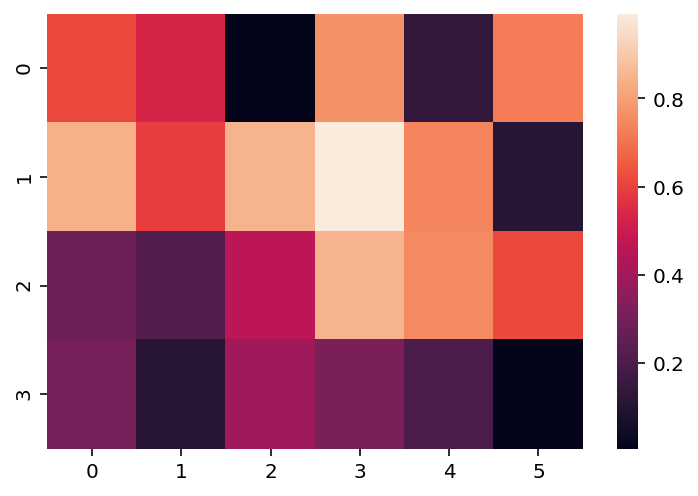

In [26]:

heatmap = sb.heatmap(data)
plt.show()

In [134]:
data = pred.numpy()[0][0]
print(data.shape)
data

(44,)


array([ 1.8066631e-03,  4.0970431e-03, -3.7693402e-03,  1.9031217e-03,
        9.1683231e-03,  3.0595269e-03, -2.1485640e-03, -4.1732227e-04,
       -1.8379760e-03,  3.2344877e-03, -1.3668761e-03, -1.6412414e-03,
        2.4035433e-03,  2.9971253e-03, -2.1432352e-04, -3.3859396e-03,
        3.3944682e-03,  1.7401045e-03, -3.7052846e-03, -6.9383131e-03,
        5.2163494e-05, -6.1840634e-05, -1.6004911e-03, -4.0759542e-04,
       -3.2169160e-03,  3.5134573e-03,  4.0343276e-04,  6.1410549e-04,
        8.4729283e-04,  3.0392280e-03, -3.0622645e-03, -7.2403094e-03,
        4.4046802e-04, -7.6324900e-04, -3.2540888e-03,  5.1201172e-03,
        4.6449588e-03, -1.9592522e-03,  9.8038383e-04,  5.1315897e-03,
       -2.4556799e-03,  1.8116247e-03,  4.2463704e-03, -2.0656143e-03],
      dtype=float32)

In [135]:
data = pred.numpy()[0][0].reshape((44,1))
print(data.shape)
data

(44, 1)


array([[ 1.8066631e-03],
       [ 4.0970431e-03],
       [-3.7693402e-03],
       [ 1.9031217e-03],
       [ 9.1683231e-03],
       [ 3.0595269e-03],
       [-2.1485640e-03],
       [-4.1732227e-04],
       [-1.8379760e-03],
       [ 3.2344877e-03],
       [-1.3668761e-03],
       [-1.6412414e-03],
       [ 2.4035433e-03],
       [ 2.9971253e-03],
       [-2.1432352e-04],
       [-3.3859396e-03],
       [ 3.3944682e-03],
       [ 1.7401045e-03],
       [-3.7052846e-03],
       [-6.9383131e-03],
       [ 5.2163494e-05],
       [-6.1840634e-05],
       [-1.6004911e-03],
       [-4.0759542e-04],
       [-3.2169160e-03],
       [ 3.5134573e-03],
       [ 4.0343276e-04],
       [ 6.1410549e-04],
       [ 8.4729283e-04],
       [ 3.0392280e-03],
       [-3.0622645e-03],
       [-7.2403094e-03],
       [ 4.4046802e-04],
       [-7.6324900e-04],
       [-3.2540888e-03],
       [ 5.1201172e-03],
       [ 4.6449588e-03],
       [-1.9592522e-03],
       [ 9.8038383e-04],
       [ 5.1315897e-03],


In [179]:
def plot_pred(pred, timestep):
    data = pred.numpy()[0][0].reshape((44,1))
    
    fig, ax = plt.subplots(figsize=(3,12))         # Sample figsize in inches
    heatmap = sb.heatmap(data, annot=True, linewidths=.5, ax=ax)
    plt.title('Network Output Distribution',fontsize=18)
    plt.xlabel('Softmax Layer at Timestep: {}'.format(timestep), fontsize=18)
    plt.ylabel('Pitch Prediction Indices', fontsize=18)
    plt.yticks(rotation=0)
    plt.show()

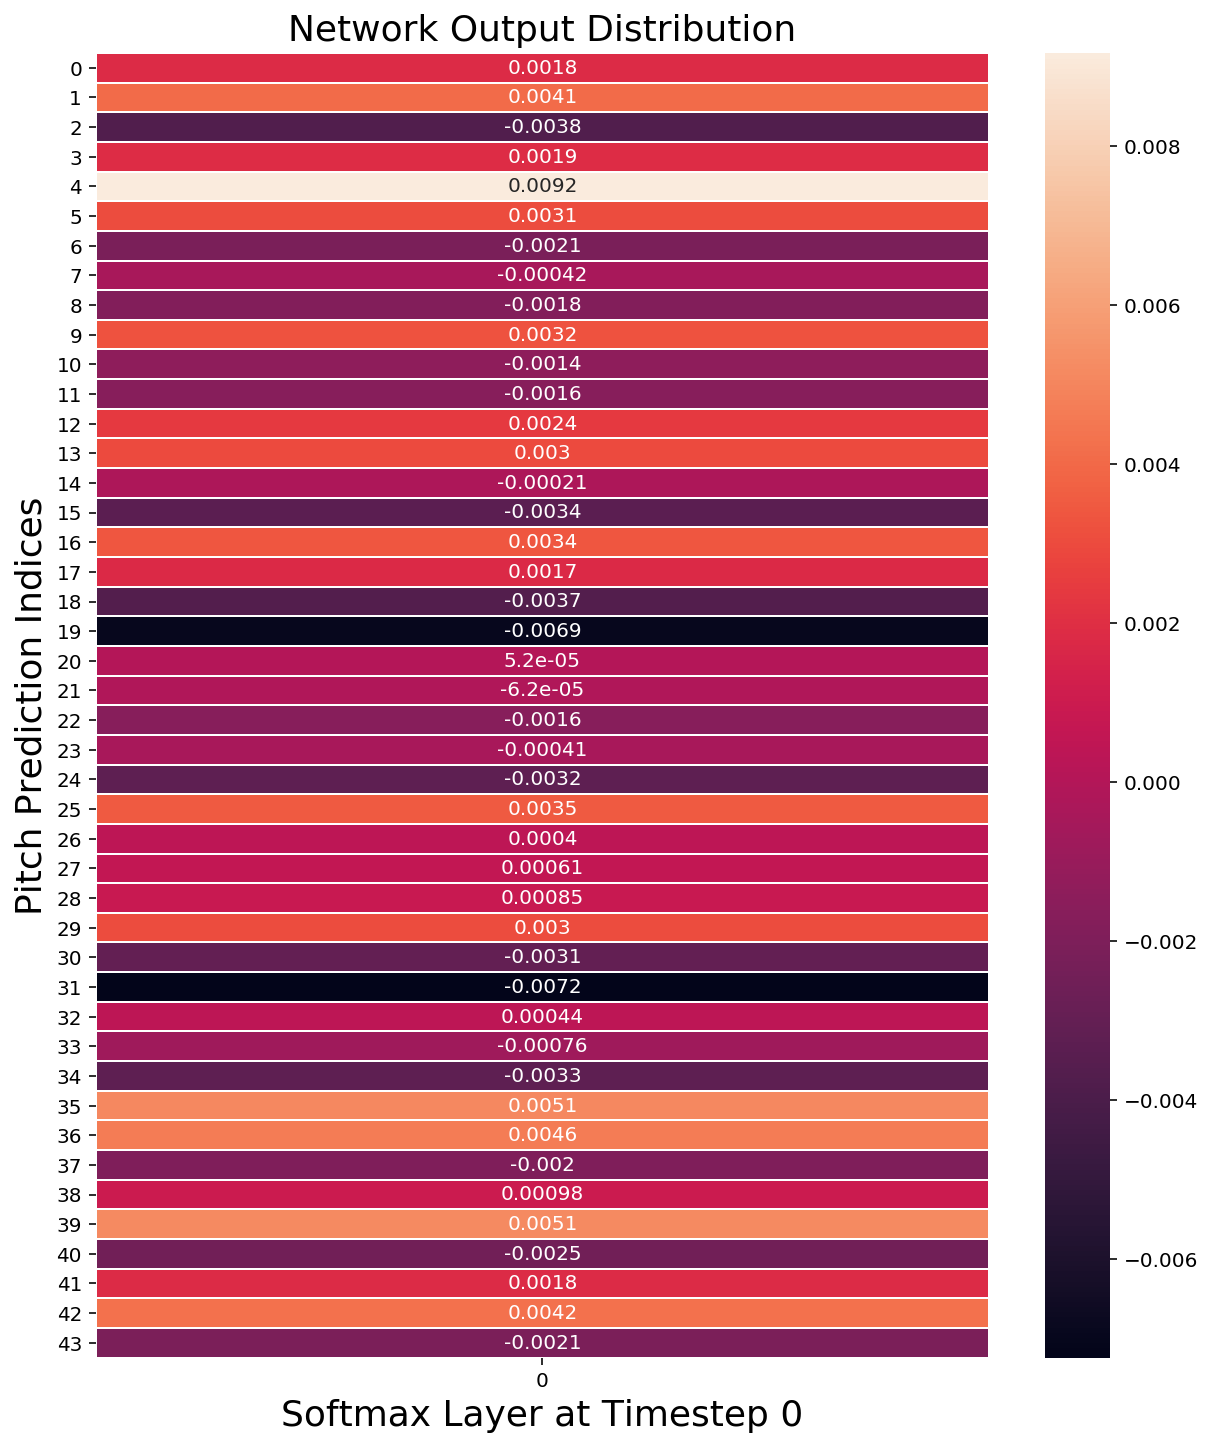

In [175]:
fig, ax = plt.subplots(figsize=(10,12))         # Sample figsize in inches
heatmap = sb.heatmap(data, annot=True, linewidths=.5, ax=ax)
plt.title('Network Output Distribution',fontsize=18)
plt.xlabel('Softmax Layer at Timestep 0', fontsize=18)
plt.ylabel('Pitch Prediction Indices', fontsize=18)
plt.yticks(rotation=0)
plt.show()

### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

In [25]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([33, 12,  8,  2, 25, 32, 43,  2, 20, 31, 30,  6,  8, 20, 26, 42, 15,
        6, 21,  3, 42,  3, 40,  4, 31, 21, 17,  9, 43, 32, 29, 40,  9,  3,
       31,  7, 17, 13,  3,  1,  7, 32, 18, 25, 32,  3, 25, 41])

In [49]:
print("Input (MIDI numbers): \n",idx2midi[X[0]])
print()
print("Untrained Next Pitch Predictions (MIDI numbers): \n", idx2midi[sampled_indices])

Input (MIDI numbers): 
 [69 69 71 73 75 76 76 75 76 73 74 73 71 73 71 69 71 71 73 74 74 73 71 73
 71 73 73 73 74 76 78 78 77 78 80 81 73 74 73 71 71 76 78 76 74 73 74 71]

Untrained Next Pitch Predictions (MIDI numbers): 
 [80 59 55 49 72 79 90 49 67 78 77 53 55 67 73 89 62 53 68 50 89 50 87 51
 78 68 64 56 90 79 76 87 56 50 78 54 64 60 50 48 54 79 65 72 79 50 72 88]


## Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

In [64]:
### Defining the loss function ###

'''Define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

'''Compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(Y, pred) 

print("Prediction shape: ", pred.shape, " # (num_sequences, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 48, 44)  # (num_sequences, sequence_length, vocab_size)
scalar_loss:       3.7831612


### Hyperparameter setting and optimization

In [66]:

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # defines the batch size (num_sequences) per training iteration: experiment between 1 and 64
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
#vocab_size = len(pitch_vocab) #already set above
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
CHECKPOINT_DIR = './training_checkpoints'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "my_ckpt")

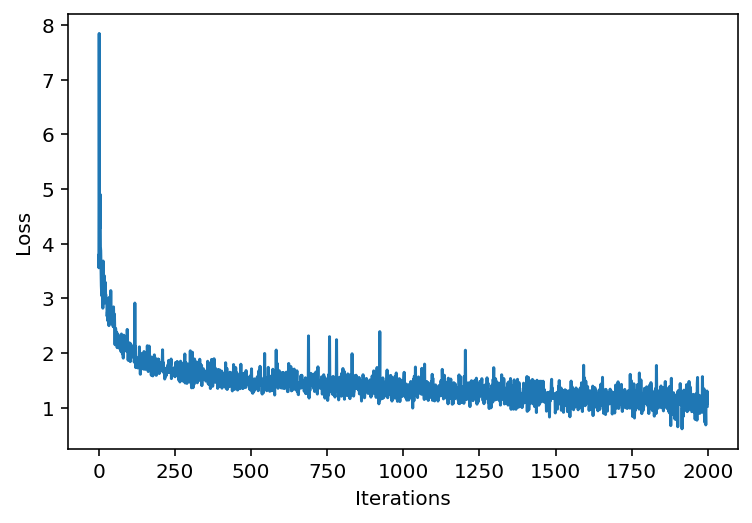

100%|█████████▉| 1999/2000 [52:49<00:01,  1.62s/it]

We have 1668 melodies to choose from.
Melody sequence random choices for training: [ 386 1029  747  550]


100%|██████████| 2000/2000 [52:50<00:00,  1.59s/it]


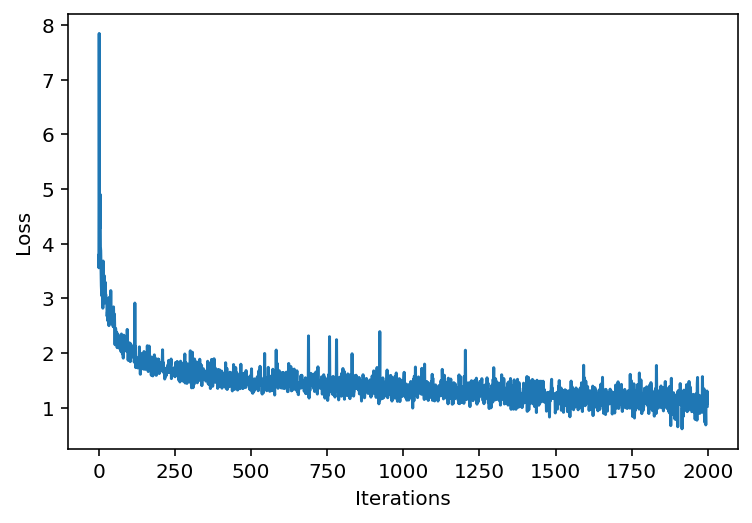

In [82]:
### Define optimizer and training operation ###

'''Instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''Instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mit_util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(padded_melodies, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive note (remember, we are using the MIDI representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive notes. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated piece using a Music21 stream in the MIDI format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [83]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, num_sequences=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(CHECKPOINT_DIR))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (1, None, 256)            11264     
_________________________________________________________________
lstm_8 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_8 (Dense)              (1, None, 44)             45100     
Total params: 5,303,340
Trainable params: 5,303,340
Non-trainable params: 0
_________________________________________________________________


### The prediction procedure

Now, we're ready to write the code to generate music in the MIDI/Music21 format:

* Initialize a "seed" start pitch and the RNN state, and set the number of pitches we want to generate.

* Use the start pitch and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted pitch. This predicted pitch is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

In [163]:
### Prediction of a generated song ###
#Input:
    # model: trained model with loaded training weights
    # start_pitch: (int) a MIDI number representing the starting note for the sequence
    # generation_length: (int) the desired length of the generated sequence
#Output:
    #A list of MIDI pitches of length `generation_length`+1 representing the predicted pitch sequence
def generate_melody(model, start_pitch=69, generation_length=32):
  # Evaluation step (generating pitch sequences using the learned RNN model)

    '''Convert the start pitch to a number (vectorize)'''
    input_eval = [midi2idx[start_pitch]]
    input_eval = tf.expand_dims(input_eval, 0)

  # Melody sequence list to store our results
    melody_sequence = [start_pitch]

  # Here batch size == 1
    model.reset_states()
    tqdm._instances.clear()

    for timestep in tqdm(range(generation_length)):
        '''Evaluate the inputs and generate the next character predictions'''
        predictions = model(input_eval)
        
        if timestep % 10 == 0:     
            plot_pred(predictions, timestep)
            #print('Predictions: ',predictions.shape)
      
        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
      
        '''Use a multinomial distribution to sample'''
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)
      
        '''Add the predicted pitch to the generated sequence!'''
        melody_sequence.append(idx2midi[predicted_id])
        
    
    return melody_sequence

  0%|          | 0/32 [00:00<?, ?it/s]

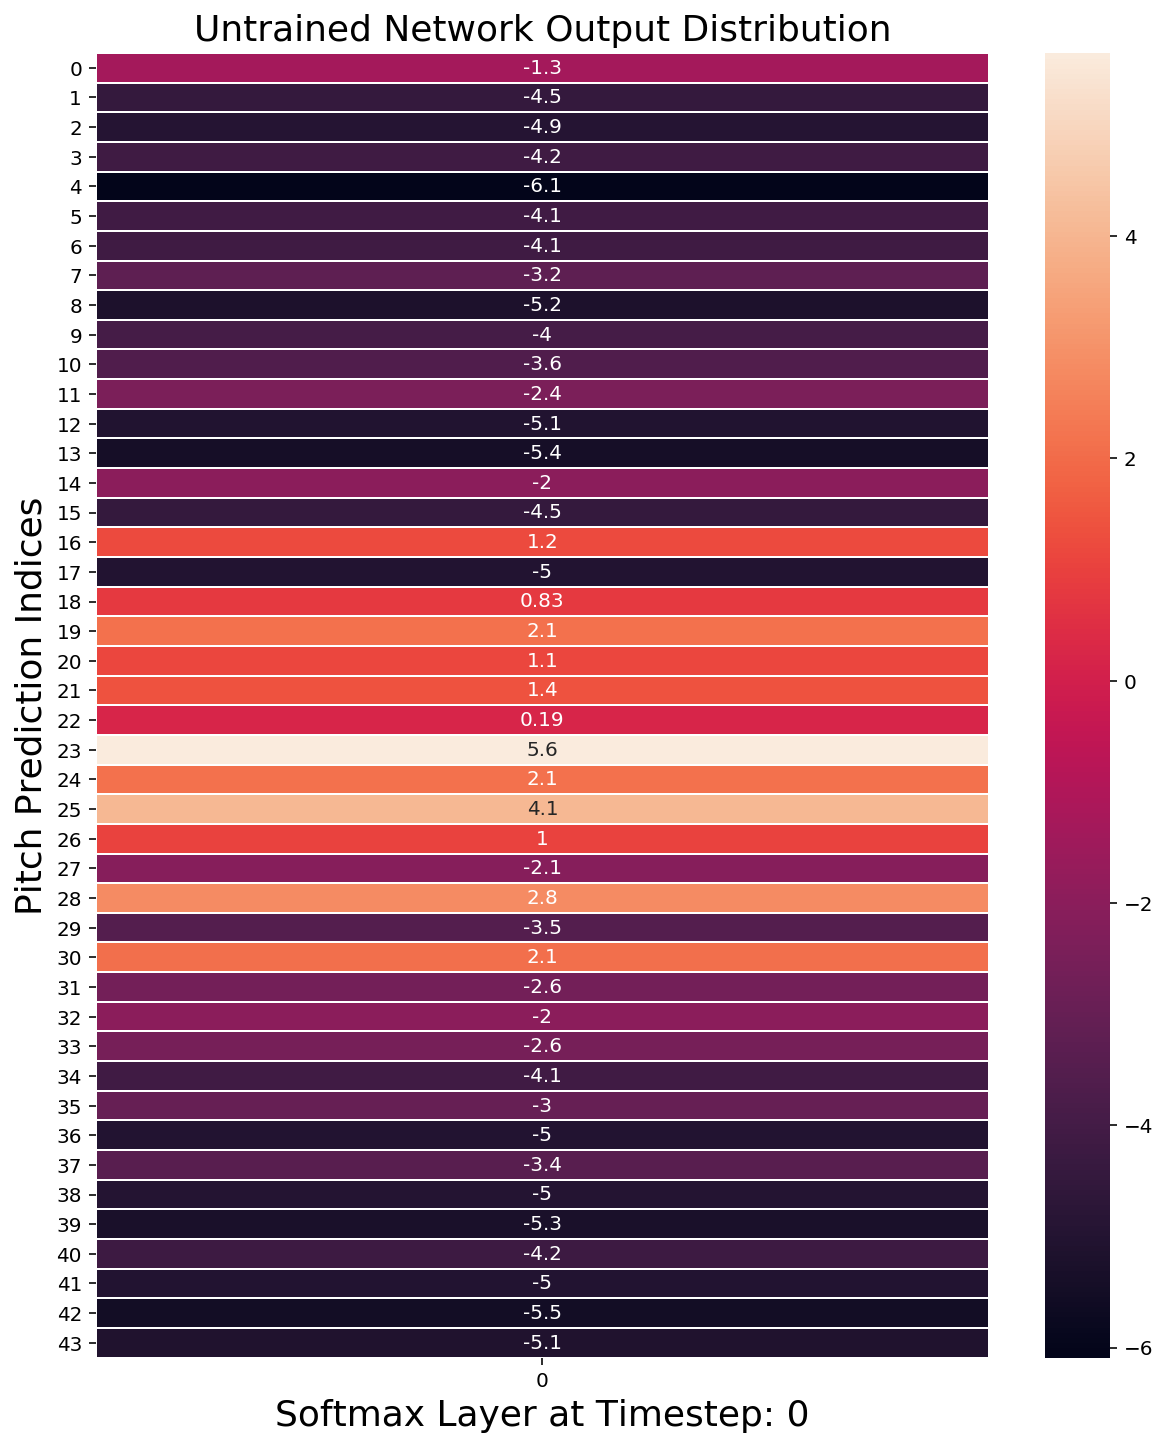

 31%|███▏      | 10/32 [00:01<00:07,  2.99it/s]

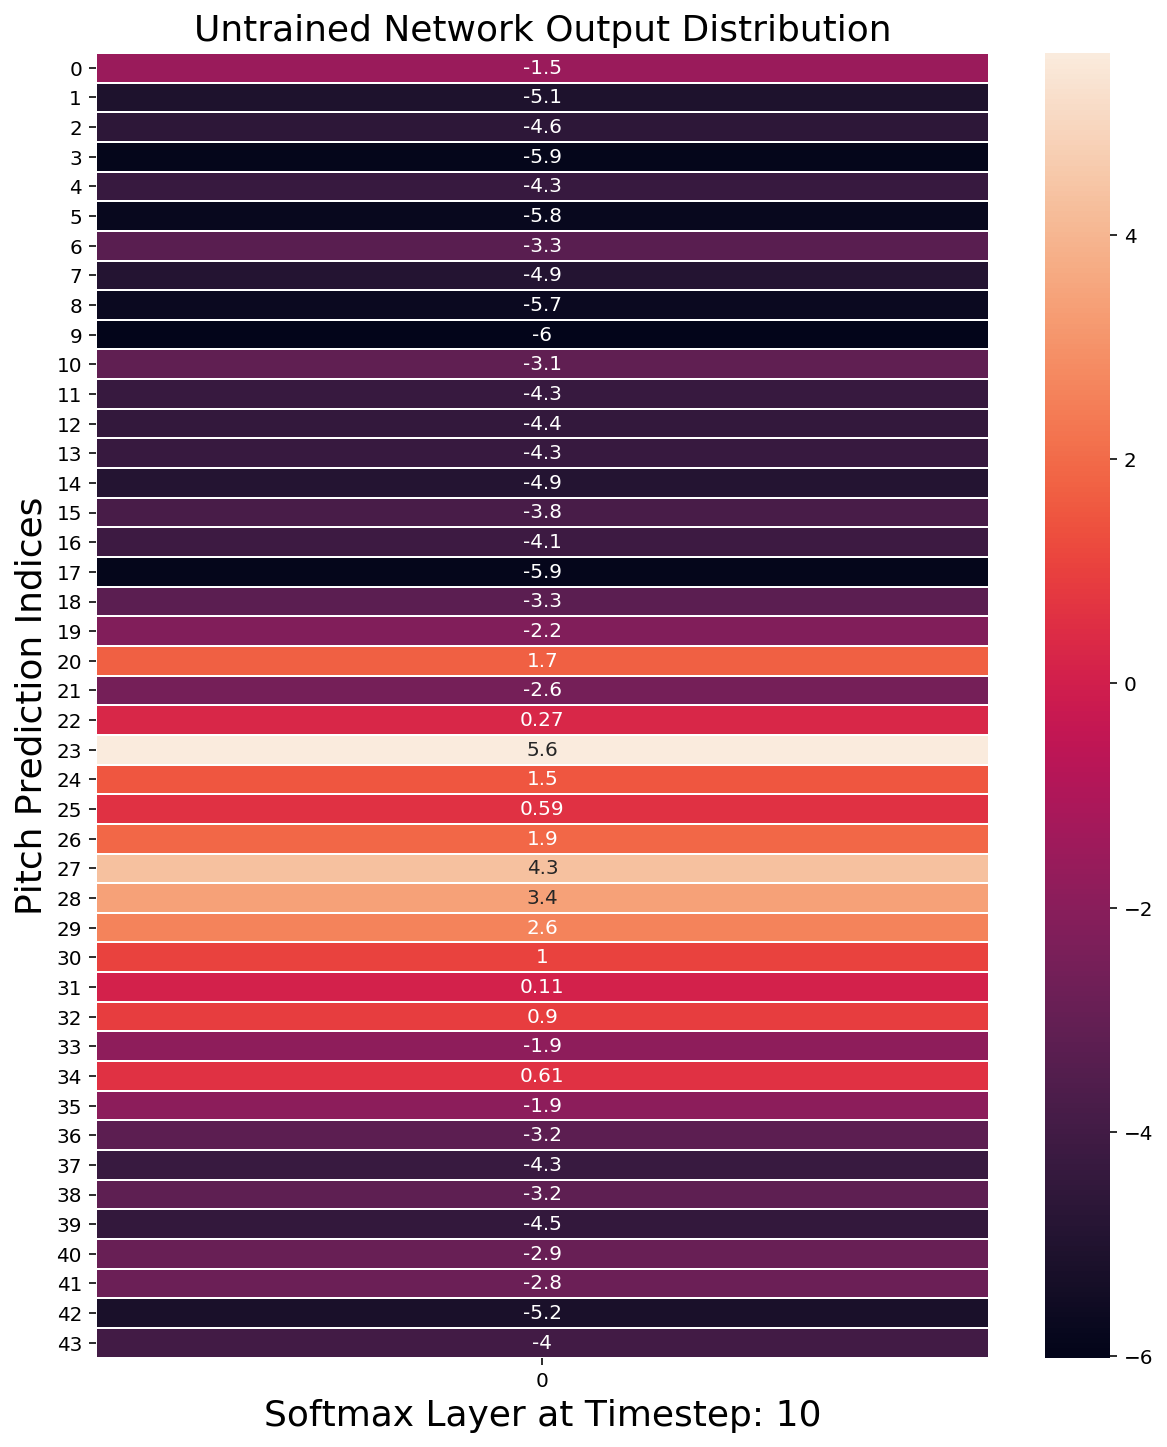

 59%|█████▉    | 19/32 [00:02<00:02,  6.30it/s]

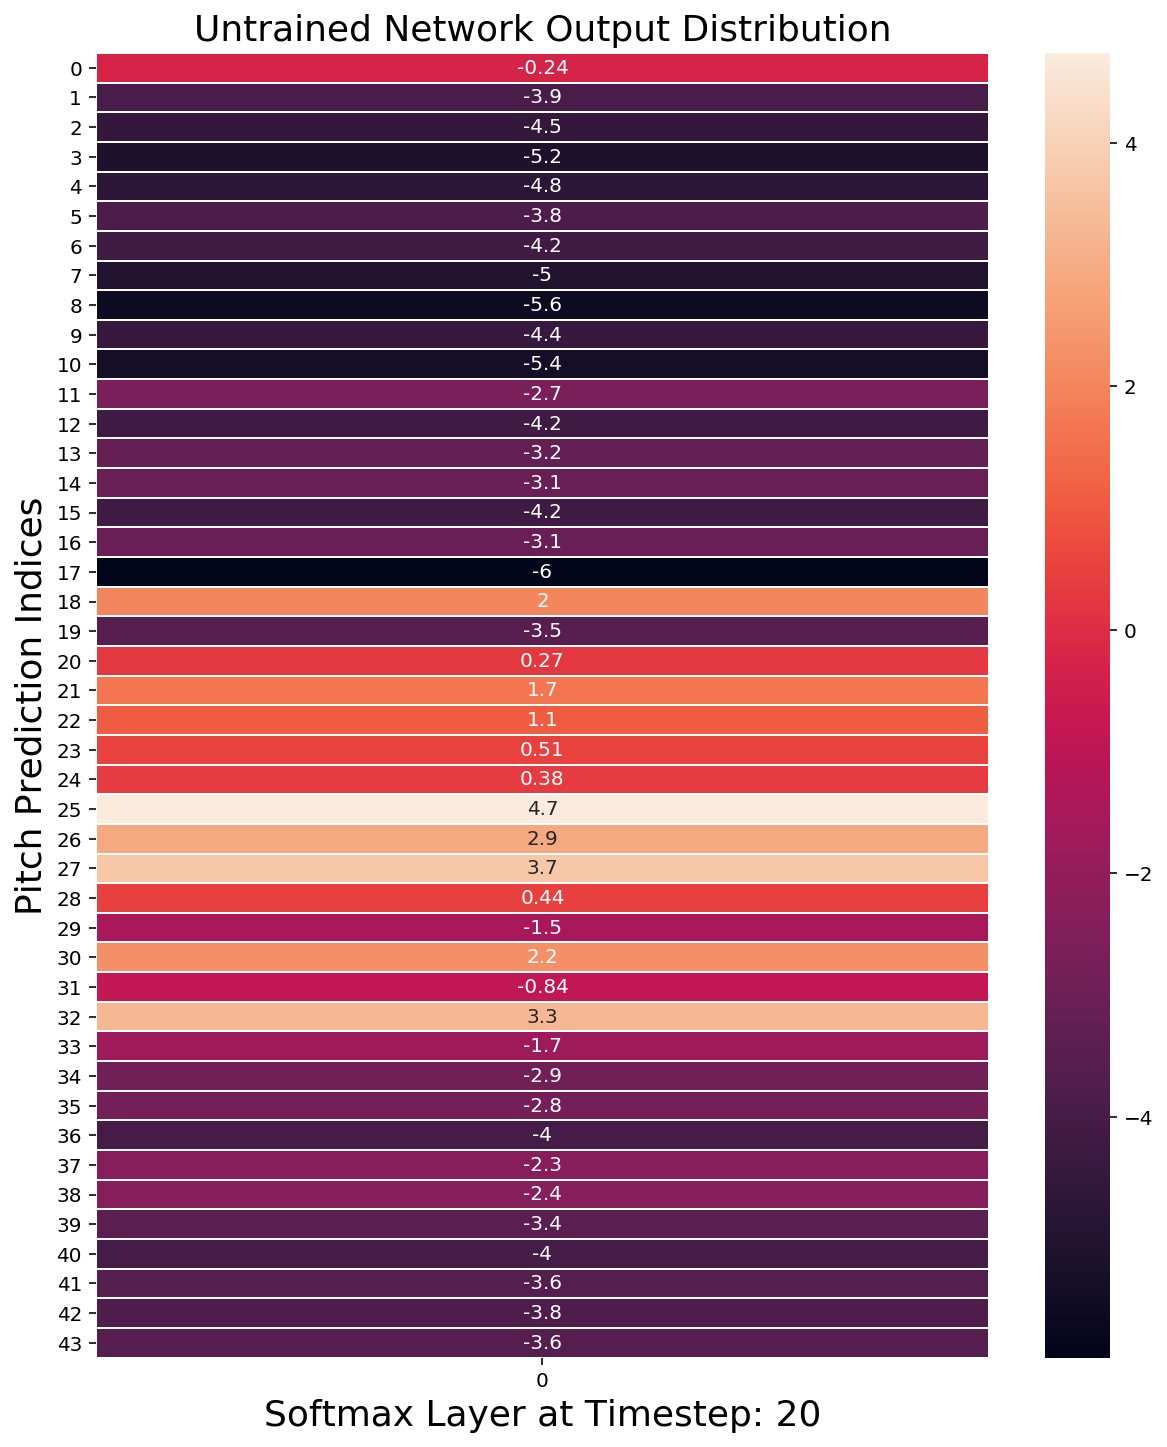

 91%|█████████ | 29/32 [00:03<00:00,  8.60it/s]

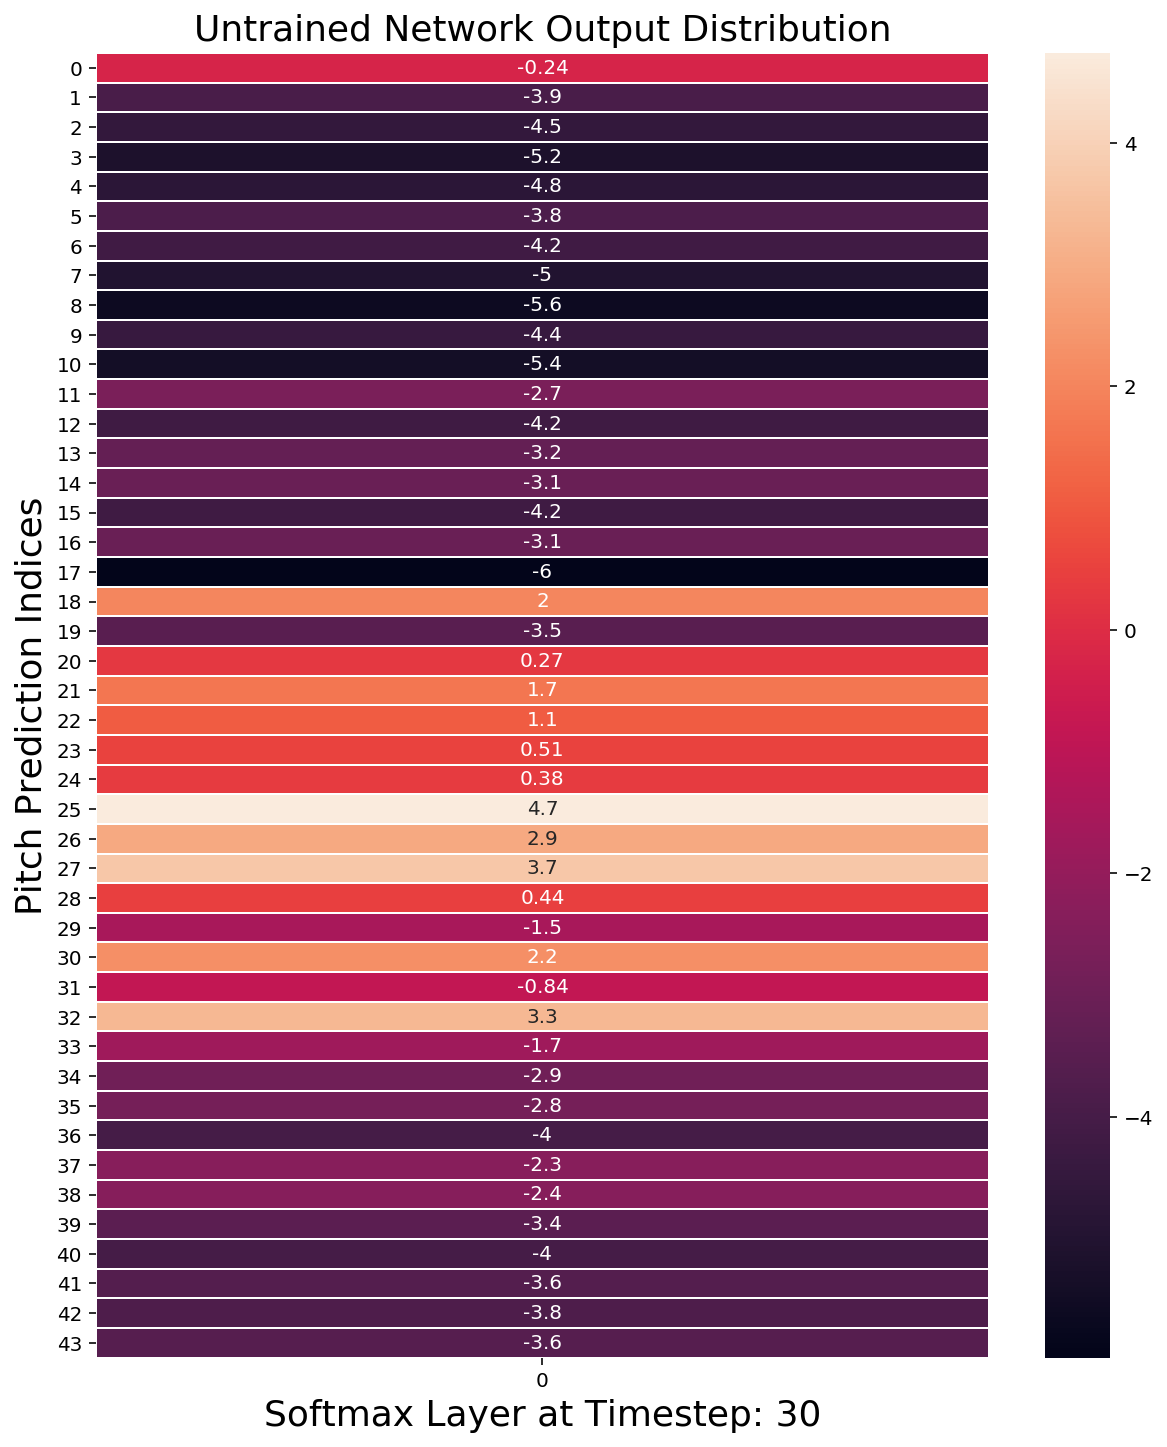

100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[70,
 70,
 70,
 72,
 74,
 74,
 70,
 70,
 72,
 72,
 74,
 74,
 70,
 72,
 72,
 72,
 74,
 70,
 72,
 65,
 72,
 72,
 74,
 70,
 70,
 70,
 72,
 72,
 74,
 72,
 72,
 79,
 80]

In [152]:
mel_sequence = generate_melody(model, 70)
mel_sequence

In [144]:
len(mel_sequence)

33

In [145]:
def melody2music(mel_sequence):
    d = duration.Duration(1.0) #For now, the default duration is a quarter-note
    
    composed_stream = stream.Stream()
    for curr_pitch in mel_sequence:
        p = pitch.Pitch(curr_pitch)
        n = note.Note()
        n.pitch = p
        n.duration = d
        composed_stream.append(n)
    
    return composed_stream

In [154]:
comp1 = melody2music(mel_sequence)
comp1

<music21.stream.Stream 0x1a43161eb8>

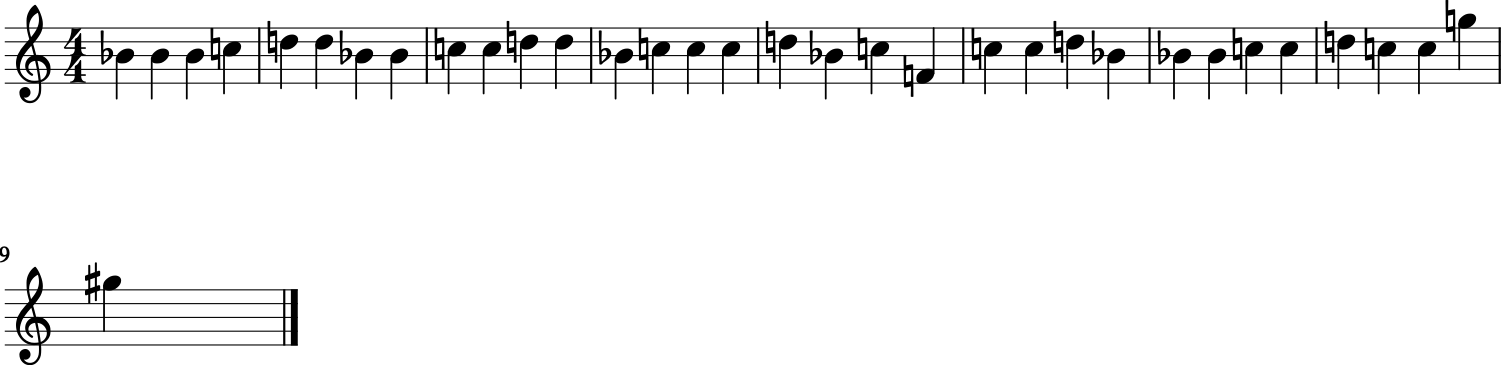

In [183]:
comp1.show()

In [156]:
comp1.show('midi')

In [184]:
comp1.write('midi', 'first_comp.mid')

'first_comp.mid'

  0%|          | 0/32 [00:00<?, ?it/s]

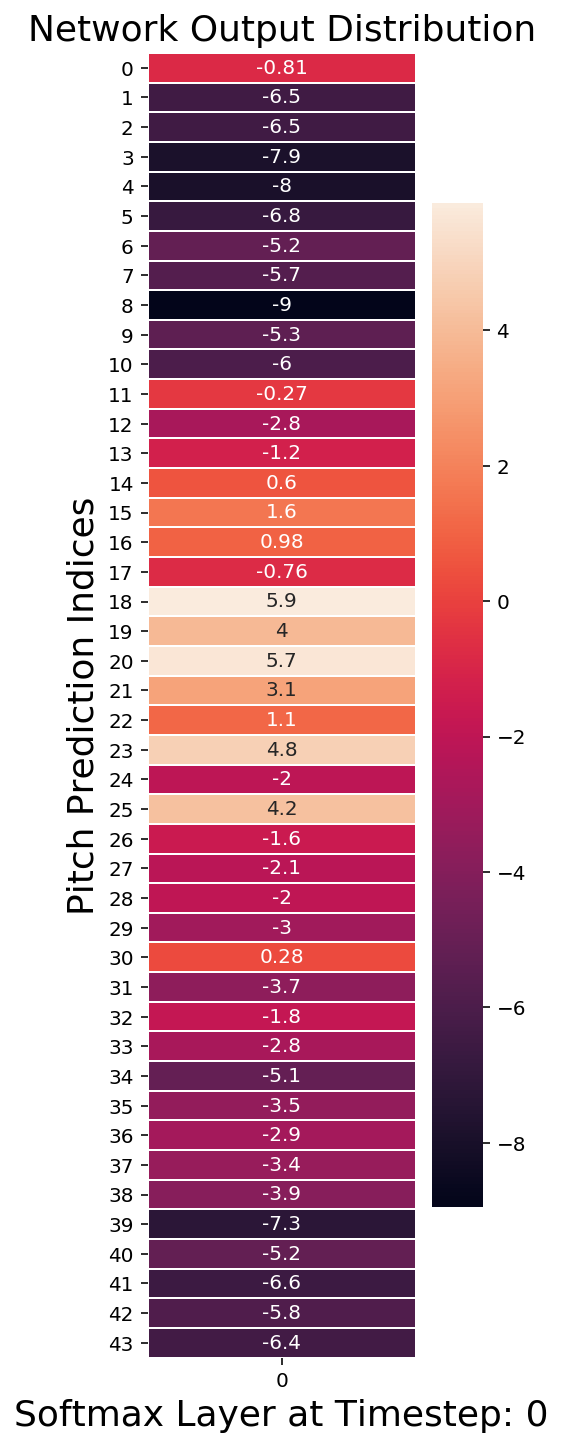

 31%|███▏      | 10/32 [00:01<00:05,  3.93it/s]

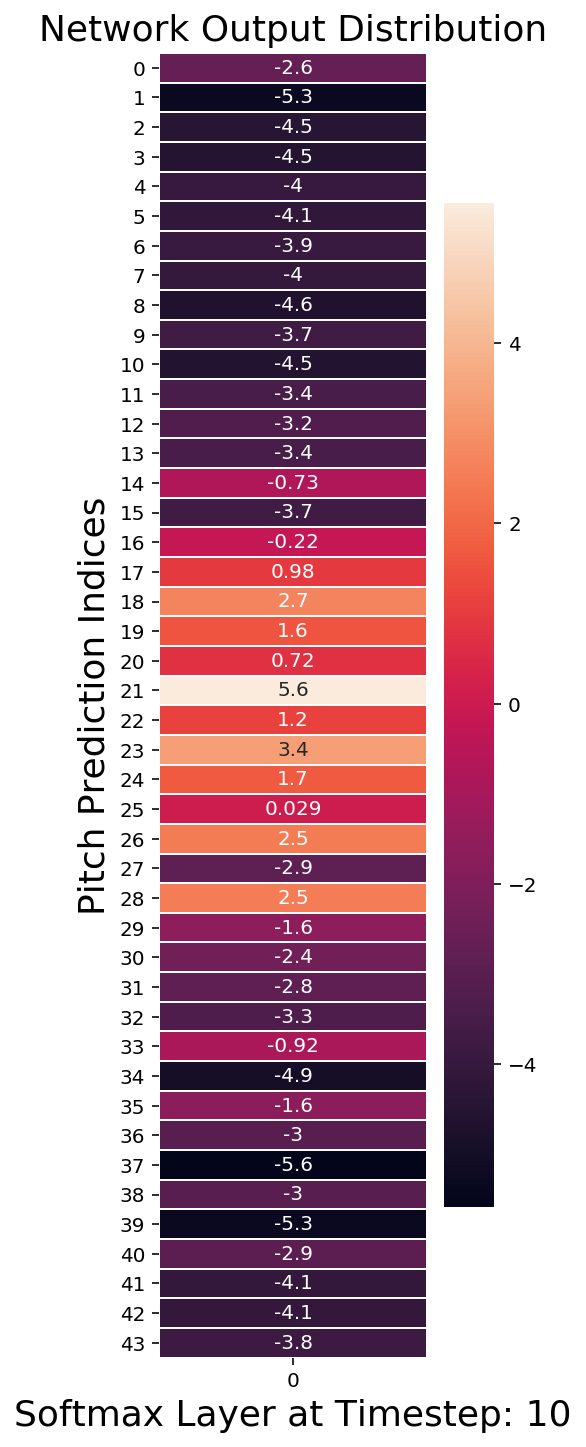

 62%|██████▎   | 20/32 [00:02<00:01,  9.13it/s]

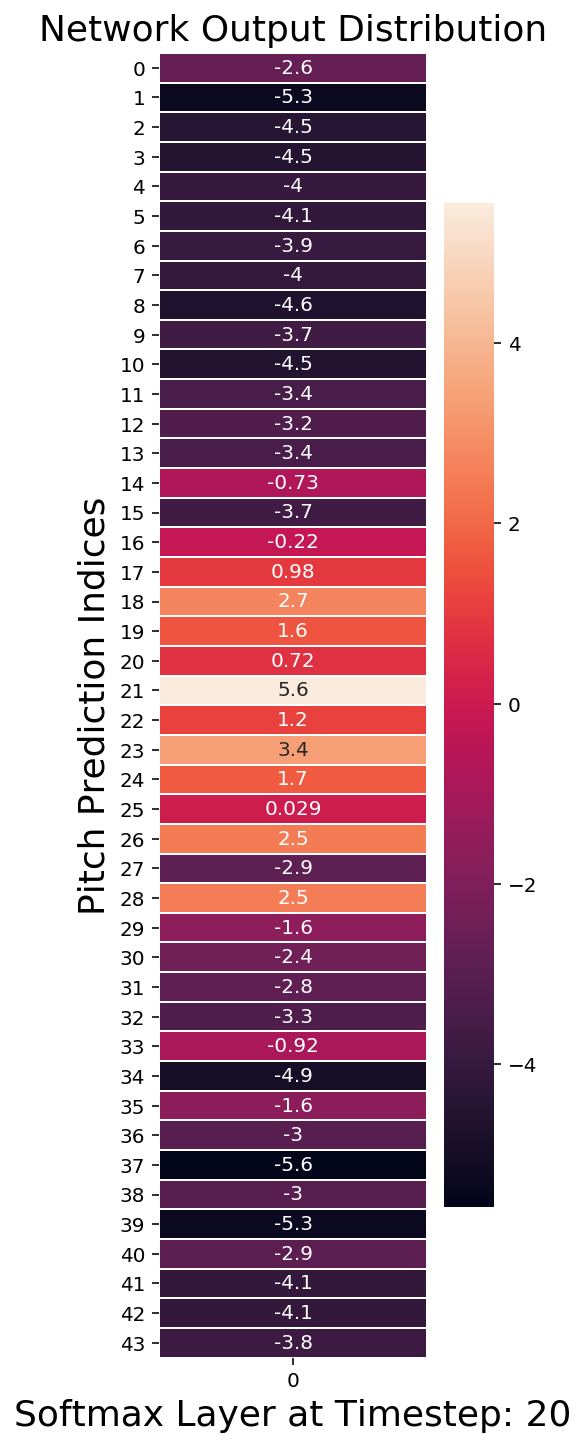

 88%|████████▊ | 28/32 [00:03<00:00,  8.75it/s]

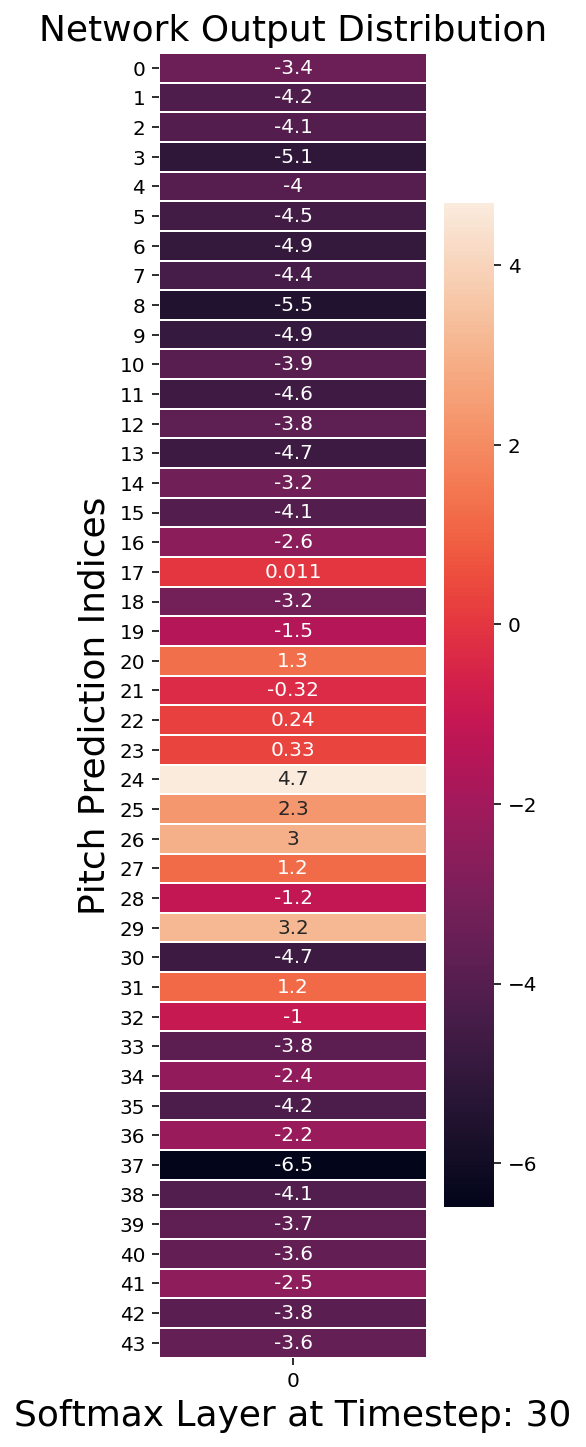

100%|██████████| 32/32 [00:04<00:00,  7.87it/s]


[65,
 72,
 72,
 74,
 70,
 72,
 72,
 72,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 63,
 66,
 63,
 70,
 73,
 83,
 71,
 71,
 71]

In [180]:
mel_sequence2 = generate_melody(model, 65)
mel_sequence2

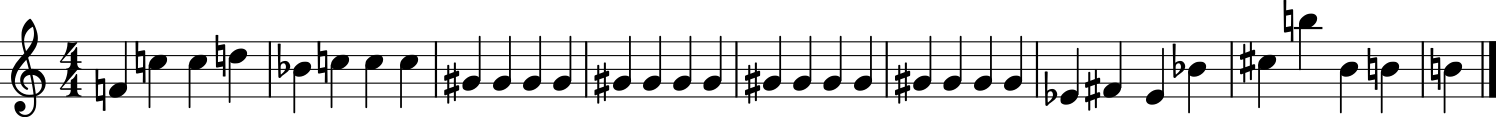

In [181]:
comp2 = melody2music(mel_sequence2)
comp2.show()

In [182]:
comp2.show('midi')

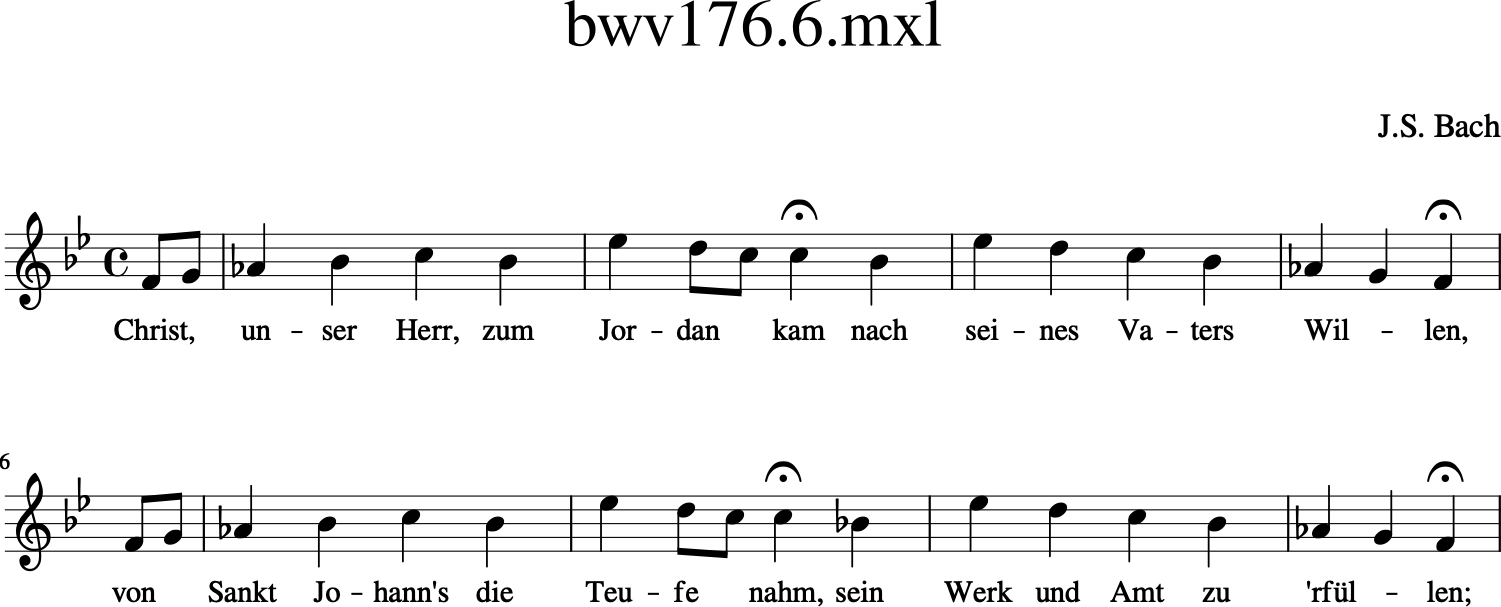

In [185]:
#For comparison
bachCorpus = corpus.getComposer('bach')
pieceScore = corpus.parse(bachCorpus[69])
melodyPart = pieceScore.getElementsByClass('Part')[0] 
melodyPart.show()

In [186]:
melodyPart.show('midi')